
<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024

- **Integrante 1: Julian Mora**
- **Integrante 2: Miguel Zapata**

Uno de los fenómenos más grandes que se presentan hoy en día son las opiniones de los usuarios sobre diferentes temas a través de Internet. Esta opinión es muy valiosa ya que permite saber en tiempo real y de primera mano los sentimientos que tienen las personas sobre un producto o servicio.

Es por ello, que una cadena hotelera en Andalucía ha decidido extraer la información de las opiniones de sus usuarios que han publicado en internet. Con el fin de poder entender cuáles son las ideas principales de los usuarios acerca de sus servicios, qué aspectos resaltan ellos sobre su servicios y, lo más importante, saber en qué pueden mejorar. Además, con este banco de datos esperan poder entrenar un modelo que les permita automáticamente determinar el sentimiento del usuario basado en las nuevas opiniones que puedan dejar.

Para poder tomar decisiones en este estudio, se debe presentar:

* Un análisis de las palabras más importantes en cada una de las categorías que le den relevancia a la cadena hotelera.

* Un proceso de limpieza y transformación de datos idóneo para el entrenamiento de los algoritmos.

* Una tabla comparativa, mostrando el rendimiento los dos mejores modelos entrenados con Naïve Bayes y KNN.

* A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?


**Datos**: Big_AHR.csv

## Diccionario de Datos

Se dan a disposición 13330 reviews de los usuarios los caules están compuestos de la siguiente forma:

* **Review’s title**: Título del review dado por el usuario.
* **5-scale rating**: Calificación del usuario. Escala de 1 a 5.
* **Text**: Review del usuario.
* **City_Region**: Región donde pertenece el hotel.
* **Hotel’s name**: Nombre del hotel evaluado.
* **Binary sentiment label** Clasificación sentimental. Donde 0 es Negativo, 1 es Positivo y 3 es Neutral.

### Librerías e importación de datos

In [1]:
# Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Nube de palabras
from wordcloud import WordCloud

# Preprocesamiento de textos
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

/tmp/ipykernel_20281/851405870.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to /home/miguel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/miguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Importar datos
reviews = pd.read_csv('Big_AHR.csv', index_col=0)

### Exploración Inicial

In [3]:
# Tipos de datos y NAs
print(reviews.info())
print(reviews.isna().sum())
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 18172 entries, 0 to 18171
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18172 non-null  object
 1   rating       18172 non-null  int64 
 2   review_text  18172 non-null  object
 3   location     16356 non-null  object
 4   hotel        16356 non-null  object
 5   label        18172 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 993.8+ KB
None
title             0
rating            0
review_text       0
location       1816
hotel          1816
label             0
dtype: int64


,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


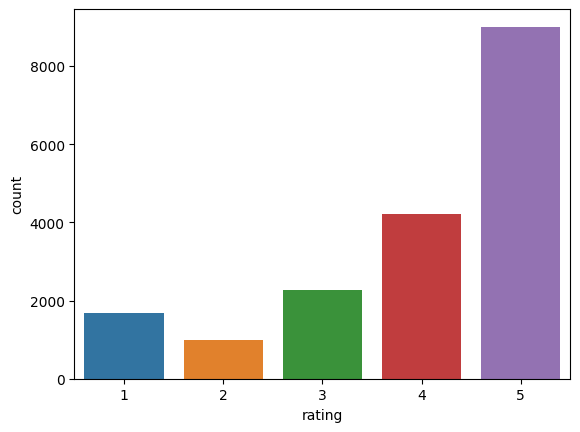

In [4]:
# Visualización de la variable objetivo
fig, ax = plt.subplots()
sns.countplot(data=reviews, x='rating')
plt.show()

Se ve un imbalance en la variable objetivo. No vemos necesario técnicas de remuestreo (undersampling o oversampling) porque los modelos que vamos a usar (Naive Bayes, KNN y GradientBoosting) son relativamente robustos a imbalances.

### Análisis de Palabras Clave
Vemos que varias de las palabras más importantes son:
- Habitación
- Hotel
- Baño
- Personal
- Servicio
- Recepción

---------- Words for Rating: 1 ----------


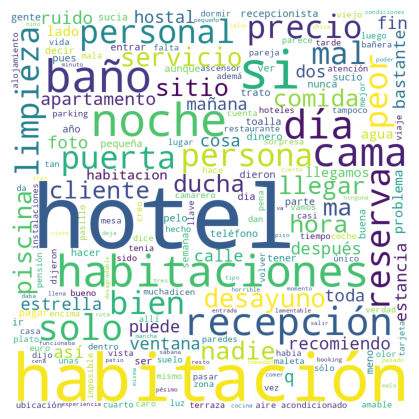

---------- Words for Rating: 2 ----------


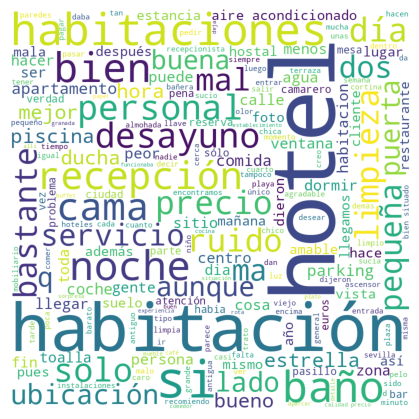

---------- Words for Rating: 3 ----------


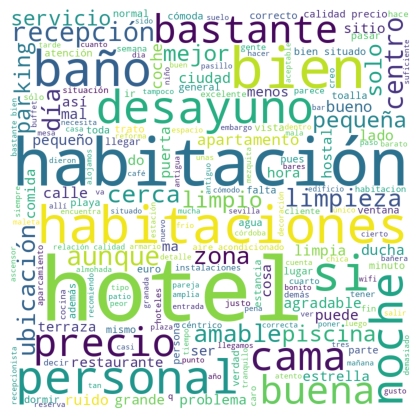

---------- Words for Rating: 4 ----------


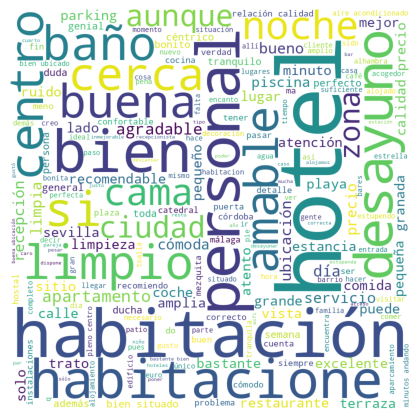

---------- Words for Rating: 5 ----------


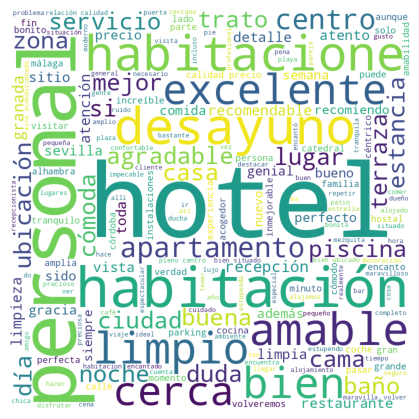

In [5]:
stop_words = set(stopwords.words('spanish'))

def mostrar_grafico(palabras,stopwords=[]):
    comment_words = ''

    # iterate through the csv file
    for val in palabras:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

for i in range(1, 6):
    print(f'---------- Words for Rating: {i} ----------')
    mostrar_grafico(reviews.loc[reviews['rating'] == i, 'review_text'], stopwords=stop_words)

### Limpieza y transformación
Vamos a unir las variables 'title' y 'review_text'. También vamos a quitar 'label', 'location' y 'hotel'. Haciendo un énfasis exclusivo en las reseñas de los usuarios; para el objetivo de negocio no vemos relevante incluir la ubicación y el hotel..

Adicionalmente, vamos a poner el texto en mínuscula, tokenizar por palabras, eliminar stopwords y puntuación.

In [6]:
# Seleccionar carácteristicas
reviews['text'] = reviews['title'] + ' ' + reviews['review_text']
X, y = reviews['text'], reviews['rating']

# Split del training y testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape)

(14537,) (3635,)


In [7]:
# Preprocesamiento de textos
punctuation = set(string.punctuation)
stemmer = SnowballStemmer('spanish')

def preprocess_text(text):
    tokens = word_tokenize(text.lower()) # Pasar texto a mínuscula y tokenizar
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation] # Filtrar stopwords y puntuación
    tokens_stemmed = [stemmer.stem(word) for word in tokens] # Stemming
    return ' '.join(tokens_stemmed)

# Transformador customizado para agregar al pipeline
class TextProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [preprocess_text(text) for text in X]

In [8]:
X[y == 1].head()

58     Suciedad intolerable Jamás me he encontrado un...
59     Lamentable Lamentable elegir un hotel de cuatr...
73     SEVILLA CENTER, UN DISGUSTO EN EL CENTRO DE SE...
109    Ruido insoportable de discoteca Debajo de la h...
117    Muy caro para lo que es Al llegar, mientras es...
Name: text, dtype: object

### Modelo inicial
Para el modelo inicial vamos a representar los tokens con una matriz dispersa con el método de Bag-of-Words. Adicionalmente el clasificador va a ser Naive Bayes Multinomial, vamos a tomar los ratings como una variable categórica.

In [9]:
# Definir pipeline y modelo
model_1 = Pipeline([('preprocessing', TextProcessing()),
                     ('vect', CountVectorizer()), # Bag-of-words
                     ('clf', MultinomialNB())])

In [10]:
# Entrenar modelo
model_1.fit(X_train, y_train)
predicted_1 = model_1.predict(X_train)
# Rendimiento con el set de entrenamiento
print(classification_report(y_train, predicted_1))

              precision    recall  f1-score   support

           1       0.85      0.91      0.87      1347
           2       0.92      0.50      0.64       807
           3       0.69      0.68      0.69      1805
           4       0.61      0.71      0.66      3350
           5       0.88      0.84      0.86      7228

    accuracy                           0.78     14537
   macro avg       0.79      0.73      0.74     14537
weighted avg       0.79      0.78      0.78     14537



### Exploración de modelos adicionales
Vamos a explorar los modelos básicos de KNN y GradientBoosting.

In [11]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

model_2 = Pipeline([('preprocessing', TextProcessing()),
                     ('vect', CountVectorizer()),
                     ('clf', KNeighborsClassifier())])

# Gradient Boosting
model_3 = Pipeline([('preprocessing', TextProcessing()),
                     ('vect', CountVectorizer()),
                     ('clf', GradientBoostingClassifier())])

In [12]:
# Entrenar Modelos
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
predicted_2 = model_2.predict(X_train)
predicted_3 = model_3.predict(X_train)

# Rendimiento con el set de entrenamiento
print(classification_report(y_train, predicted_2))
print(classification_report(y_train, predicted_3))

              precision    recall  f1-score   support

           1       0.89      0.58      0.70      1347
           2       0.82      0.42      0.55       807
           3       0.67      0.62      0.64      1805
           4       0.63      0.62      0.62      3350
           5       0.78      0.90      0.83      7228

    accuracy                           0.74     14537
   macro avg       0.76      0.63      0.67     14537
weighted avg       0.74      0.74      0.73     14537

              precision    recall  f1-score   support

           1       0.84      0.77      0.80      1347
           2       0.90      0.44      0.59       807
           3       0.75      0.44      0.56      1805
           4       0.61      0.45      0.52      3350
           5       0.73      0.94      0.82      7228

    accuracy                           0.72     14537
   macro avg       0.77      0.61      0.66     14537
weighted avg       0.72      0.72      0.70     14537



Por el momento el que mejor le ha ido en accuracy es al modelo de Naive Bayes. En general, vemos que los modelos tienen un bajo recall, específicamente en los rating bajos, que son de nuestro mayor interés.

### Optimización de modelos

Al pipeline le agregamos el método de preprocesamiento TFIDF y a la grilla de cada modelo agregamos parametros razonables para cada modelo.

In [ ]:
# Naive Bayes
nb_clf = Pipeline([
    ('preprocessing', TextProcessing()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
    ])

nb_params = {
    'clf__alpha': (0.01, 0.001),
}

gs_nb_clf = GridSearchCV(nb_clf, nb_params)
gs_nb_clf.fit(X_train, y_train)
gs_nb_predictor = gs_nb_clf.predict(X_train)

In [ ]:
print(gs_nb_clf.best_params_)
print(classification_report(y_train, gs_nb_predictor))

In [ ]:
# KNN
knn_clf = Pipeline([
    ('preprocessing', TextProcessing()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier())
    ])

knn_params = {
    'clf__n_neighbors': (5, 10, 15),
    'clf__weights': ('uniform', 'distance')
}

gs_knn_clf = GridSearchCV(nb_clf, nb_params)
gs_knn_clf.fit(X_train, y_train)
gs_knn_predictor = gs_knn_clf.predict(X_train)

In [ ]:
print(gs_knn_clf.best_params_)
print(classification_report(y_train, gs_knn_predictor))

In [ ]:
# Gradient Boosting
gb_clf = Pipeline([
    ('preprocessing', TextProcessing()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', GradientBoostingClassifier())
    ])

gb_params = {
    'clf__min_samples_split': (2, 5, 10),
    'clf__max_depth': (3, 5)
}

gs_gb_clf = GridSearchCV(nb_clf, nb_params)
gs_gb_clf.fit(X_train, y_train)
gs_gb_predictor = gs_gb_clf.predict(X_train)

In [ ]:
print(gs_gb_clf.best_params_)
print(classification_report(y_train, gs_gb_predictor))